In [1]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
import joblib

# Features seleccionados previamente
selected_features = np.loadtxt('../models/selected_features.txt', dtype=str)

# Cargamos nuestro modelo de línea base
baseline_model = joblib.load('../models/RandomForestClassifier.pkl')

# Lectura de los subsets
X_train = pd.read_csv('../data/processed/X_train.csv')[selected_features]
X_val = pd.read_csv('../data/processed/X_val.csv')[selected_features]
X_test = pd.read_csv('../data/processed/X_test.csv')[selected_features]

y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_val = pd.read_csv('../data/processed/y_val.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

In [3]:
# Optimización de Hiperparámetros
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import RandomizedSearchCV

# K-Fold estratificado
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Pesos de las muestras
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': stats.randint(100, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': stats.randint(1, 6)
}

# Definir la métrica log-loss como métrica de evaluación
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(baseline_model, 
                                   param_distributions=param_dist, 
                                   n_iter=200,
                                   scoring=log_loss_scorer,
                                   cv=skfold, 
                                   n_jobs=-1,
                                   random_state=42, 
                                   verbose=0,
                                   refit=True, # Al encontrar los mejores hiperparámetros reajusta el modelo
                                   return_train_score=True)

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
random_search.fit(X_train, y_train, sample_weight=sample_weight)

# Obtener el mejor modelo y los mejores hiperparámetros
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluar el mejor modelo en el conjunto de entrenamiento
y_pred_train = best_model.predict_proba(X_train)[:, 1]
train_log_loss = log_loss(y_train, y_pred_train)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_val = best_model.predict_proba(X_val)[:, 1]
val_log_loss = log_loss(y_val, y_pred_val)

# Imprimir los resultados
print('Mejores hiperparámetros encontrados:')
print(best_params)
print('Log-loss en conjunto de train:', train_log_loss)
print('Log-loss en conjunto de validación:', val_log_loss)

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 152}
Log-loss en conjunto de train: 0.42976785975437887
Log-loss en conjunto de validación: 0.43857525180185875


In [4]:
from sklearn.metrics import brier_score_loss

# Predecir probabilidades de clase para datos de prueba
y_pred = best_model.predict_proba(X_val)[:, 1]

# Métricas
print(f'Log-loss of {type(best_model).__name__}: {100*log_loss(y_val, y_pred):0.2f}%')
print(f'Brier Score of {type(best_model).__name__}: {100*brier_score_loss(y_val, y_pred):0.2f}%')

Log-loss of RandomForestClassifier: 43.86%
Brier Score of RandomForestClassifier: 14.44%


In [5]:
# Calibración
from sklearn.calibration import CalibratedClassifierCV
 
calibrated_model = CalibratedClassifierCV(best_model, cv=skfold, method='isotonic', n_jobs=-1)
calibrated_model.fit(X_val, y_val)
calibrated_probs = calibrated_model.predict_proba(X_val)[:, 1]

In [6]:
# Brier score del modelo calibrado
print(f'Log-loss of {type(calibrated_model.estimator).__name__}: {100*log_loss(y_val, calibrated_probs):0.2f}%')
print(f'Brier Score of {type(calibrated_model.estimator).__name__}: {100*brier_score_loss(y_val, calibrated_probs):0.2f}%')

Log-loss of RandomForestClassifier: 39.21%
Brier Score of RandomForestClassifier: 12.81%


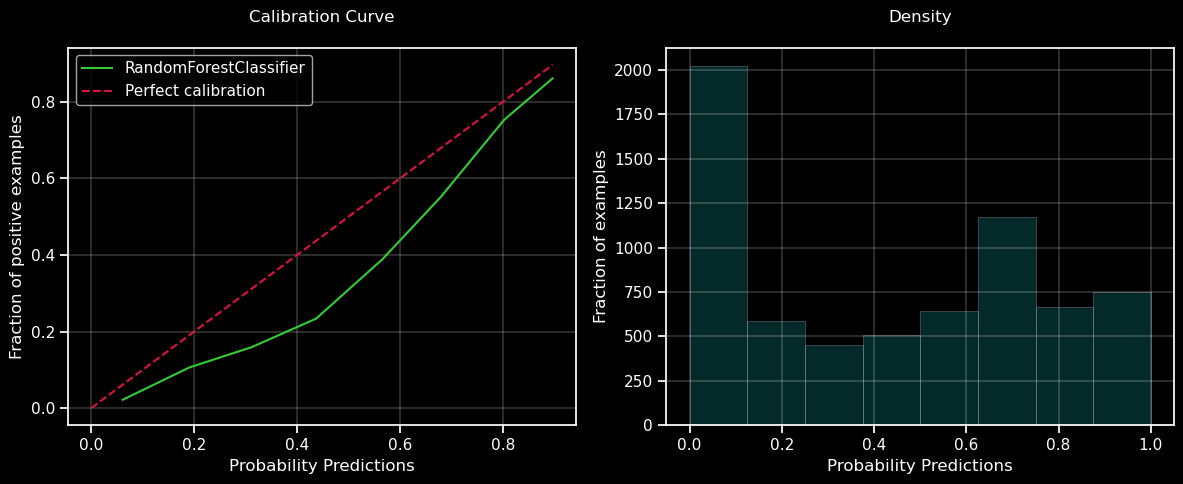

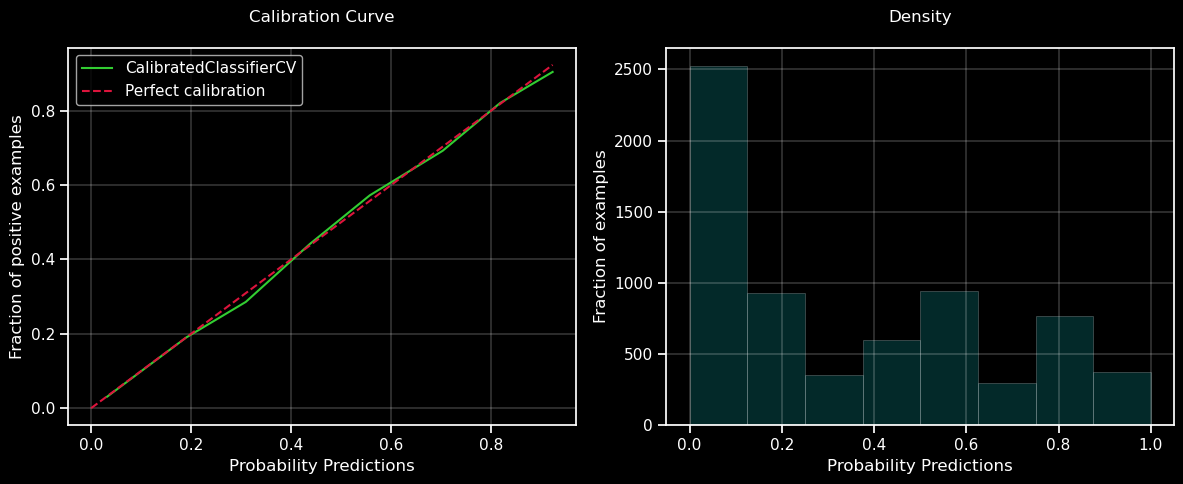

In [7]:
# A nivel visual los resultados de las comparaciones
for modelo, probs in zip([best_model, calibrated_model], [y_pred, calibrated_probs]):
    plot_calibration_curve(y_val, probs, bins=8, model=modelo)

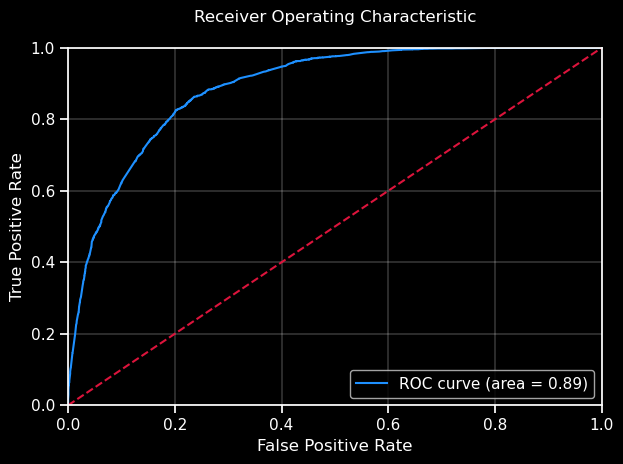

In [8]:
# Curva ROC con el modelo calibrado
roc_curve_plot(model=calibrated_model, 
               X_val=X_val,
               y_val=y_val)

In [9]:
# Reporte de clasificación del modelo calibrado
from sklearn.metrics import classification_report

print(classification_report(y_val, calibrated_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4455
           1       0.72      0.74      0.73      2337

    accuracy                           0.81      6792
   macro avg       0.79      0.79      0.79      6792
weighted avg       0.81      0.81      0.81      6792



In [10]:
# Exportando el modelo afinado
joblib.dump(calibrated_model, f'../models/Tunned{type(calibrated_model.estimator).__name__}.pkl')

['../models/TunnedRandomForestClassifier.pkl']

---
---